# Deep Convolutional Neural Networks

**Objective:** The objective of this section is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion. 

In [1]:
# import packages

!pip install tensorflow

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"


In [ ]:
# Import libraries

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
import splitfolders

from pathlib import Path
from collections import Counter
from PIL import Image, ImageOps, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display
from tensorflow.keras.applications.vgg16 import preprocess_input


In [4]:
!pip install split-folders==0.5.1

In [5]:
!unzip flowers.zip

unzip:  cannot find or open flowers.zip, flowers.zip.zip or flowers.zip.ZIP.



Total images: 4317

Distribution by class:
  daisy          764  ( 17.7%)
  rose           784  ( 18.2%)
  tulip          984  ( 22.8%)
  dandelion     1052  ( 24.4%)
  sunflower      733  ( 17.0%)


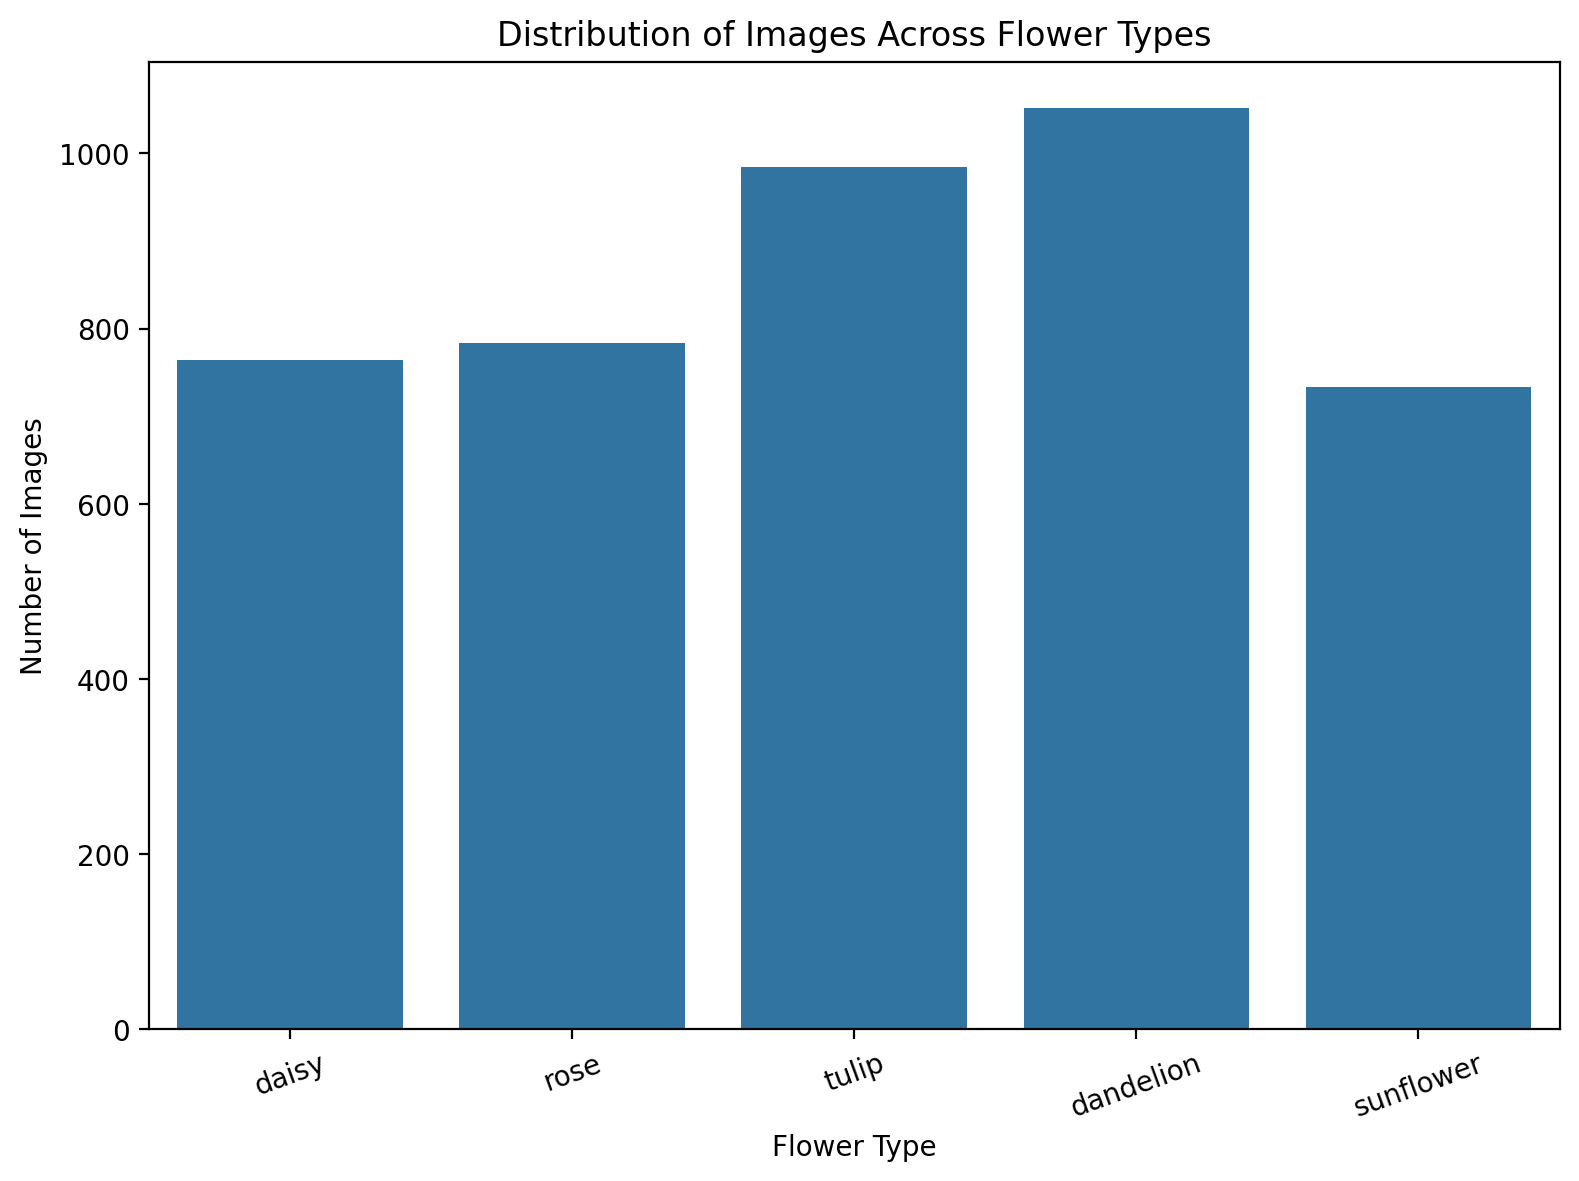

In [ ]:
#Step 1 implementation
#Hint: Take the help of split-folder python library

# Q1 What is the total number of images in the dataset, and how are they distributed across the five flower types?

file_path = '/flowers'

flower_classes = os.listdir(file_path)

img_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif', '.tiff', '.webp'}
counts = {}
for cls in flower_classes:
    cls_dir = os.path.join(file_path, cls)
    n = 0
    for root, _, files in os.walk(cls_dir):
        n += sum(1 for f in files if os.path.splitext(f)[1].lower() in img_exts)
    counts[cls] = n

total = sum(counts.values())
print(f"\nTotal images: {total}\n")

print("Distribution by class:")
for cls in flower_classes:
    cnt = counts[cls]
    pct = (cnt / total * 100) if total else 0
    print(f"  {cls:<12} {cnt:5d}  ({pct:5.1f}%)")

# Visual representation
plt.figure(figsize=(8, 6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Distribution of Images Across Flower Types")
plt.xlabel("Flower Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [9]:
# Q3)What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?

root = Path(file_path)  

rows, bad = [], 0

for cls_dir in sorted([p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]):
    for f in cls_dir.rglob("*"):
        if f.is_file() and f.suffix.lower() in img_exts and not f.name.startswith("."):
            try:
                with Image.open(f) as im:
                    im = ImageOps.exif_transpose(im)  
                    w, h = im.size
                rows.append((cls_dir.name, f.name, w, h, w*h, (w/h) if h else np.nan))
            except (UnidentifiedImageError, OSError):
                bad += 1

df = pd.DataFrame(rows, columns=["class","filename","width","height","area","aspect"])
df["size_tuple"] = list(zip(df["width"], df["height"]))

print(f"Scanned {len(df)} images", f"(skipped {bad} unreadable files)" if bad else "")

# Global summary
top_sizes = (df.value_counts(["width","height"])
               .rename("count")
               .reset_index()
               .sort_values("count", ascending=False)
               .head(10))

print("\nTop 10 most common image sizes (W×H):")
for _, r in top_sizes.iterrows():
    print(f"  {int(r.width)}×{int(r.height)}  — {int(r['count'])} images")

print(f"\nTotal unique sizes in dataset: {df['size_tuple'].nunique()}")

# Per-class summary table
per_class = (df.groupby("class")
               .agg(
                   n=("filename","count"),
                   unique_sizes=("size_tuple","nunique"),
                   min_w=("width","min"),  max_w=("width","max"),
                   min_h=("height","min"), max_h=("height","max"),
                   median_w=("width","median"), median_h=("height","median"),
                   mean_w=("width","mean"),   mean_h=("height","mean"),
                   median_ar=("aspect","median")
               )
               .sort_values("n", ascending=False)
               .round(2))

per_class

Scanned 4317 images 

Top 10 most common image sizes (W×H):
  320×240  — 604 images
  500×333  — 599 images
  240×159  — 378 images
  320×213  — 322 images
  240×240  — 219 images
  180×240  — 154 images
  159×240  — 141 images
  500×375  — 124 images
  500×332  — 118 images
  240×180  — 69 images

Total unique sizes in dataset: 386


n  unique_sizes  min_w  max_w  min_h  max_h  median_w  median_h  \
class                                                                           
dandelion  1052           208    134    500     98    436     320.0     240.0   
tulip       984           159    134   1024    134    441     320.0     240.0   
rose        784           162    150    500     80    434     320.0     240.0   
daisy       764           184    134    640    134    442     320.0     240.0   
sunflower   733           162    152    640    134    400     320.0     240.0   

           mean_w  mean_h  median_ar  
class                                 
dandelion  346.77  258.82       1.40  
tulip      336.14  248.07       1.50  
rose       327.01  244.19       1.49  
daisy      331.81  252.62       1.33  
sunflower  348.35  261.53       1.33

In [10]:
# Create a 80/10/10 split with splitfolders

in_dir  = Path(file_path)      
out_dir = in_dir.parent / "flowers_split"

if not (out_dir / "train").exists():
    splitfolders.ratio(in_dir, output=out_dir, seed=42, ratio=(0.8, 0.10, 0.10))
    print("Split created at:", out_dir)
else:
    print("Split already exists at:", out_dir)

# Sanity check of counts per split

def count_images(root_dir):
    root = Path(root_dir)
    counts = Counter()
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]):
        n = 0
        for f in cls_dir.rglob("*"):
            if f.is_file() and f.suffix.lower() in img_exts and not f.name.startswith("."):
                n += 1
        counts[cls_dir.name] = n
    return counts, sum(counts.values())

for split in ["train","val","test"]:
    c, tot = count_images(out_dir / split)
    print(f"{split:<5} total={tot}  " + "  ".join(f"{k}:{c[k]}" for k in sorted(c)))


Split already exists at: /Users/prabodhikakarunarathna/Library/CloudStorage/OneDrive-UniversityofAdelaide/Master of AI and ML/Trimester 2/AI and ML A/Assignments/Assignment3/flowers_split
train total=3019  daisy:534  dandelion:736  rose:548  sunflower:513  tulip:688
val   total=644  daisy:114  dandelion:157  rose:117  sunflower:109  tulip:147
test  total=654  daisy:116  dandelion:159  rose:119  sunflower:111  tulip:149


In [11]:
# Build generators with standard preprocessing & augmentation

IMG_SIZE   = (224, 224)   # standard size for many CNNs
BATCH_SIZE = 32
SEED       = 42

train_dir = str(out_dir / "train")
val_dir   = str(out_dir / "val")
test_dir  = str(out_dir / "test")

# Data augmentation for training; rescale everywhere
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = valid_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
print("Class indices:", class_indices)


Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.
Found 654 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [13]:
# Compute class weights from the training split (simple, effective)

y_train = train_gen.classes       
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weight)



Class weights: {0: 1.1307116104868913, 1: 0.8203804347826087, 2: 1.1018248175182481, 3: 1.1769980506822613, 4: 0.8776162790697675}


**CNN Implementation**

In [14]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755429087.430613 3864860 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755429087.430829 3864860 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

EPOCHS = 50
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                     restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight, 
    callbacks=callbacks,
    verbose=1
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1755429093.606839 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.3194 - loss: 1.7373 - val_accuracy: 0.5047 - val_loss: 1.1452
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5483 - loss: 1.0831 - val_accuracy: 0.6180 - val_loss: 1.0123
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.5909 - loss: 1.0106 - val_accuracy: 0.6087 - val_loss: 0.9996
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.6568 - loss: 0.8945 - val_accuracy: 0.6398 - val_loss: 0.9135
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.6707 - loss: 0.8552 - val_accuracy: 0.6506 - val_loss: 0.9427
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.6872 - loss: 0.8335 - val_accuracy: 0.6568 - val_loss: 0.8956
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.6943 - loss: 0.8026 - val_accuracy: 0.6817 - val_loss: 0.8202
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.7399 - loss: 0.7180 - val_accuracy: 0.711

Best epoch: 12
Validation accuracy (best): 0.7531
Training accuracy at that epoch: 0.7635
Train–Val gap: +0.0104
evaluate() Validation accuracy: 0.7531


E0000 00:00:1755429569.983648 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


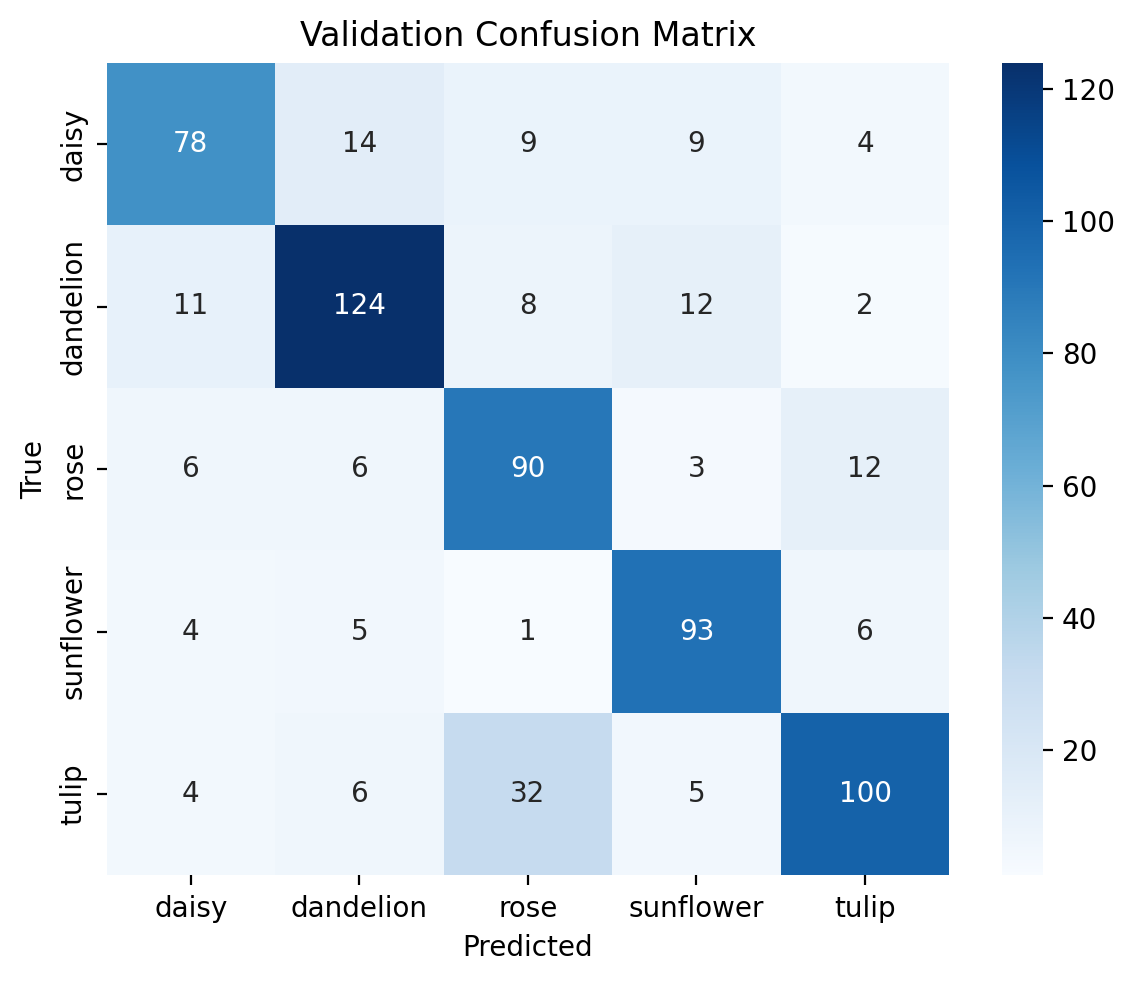

tulip        errors: 47  (support=147)
daisy        errors: 36  (support=114)
dandelion    errors: 33  (support=157)
rose         errors: 27  (support=117)
sunflower    errors: 16  (support=109)

Per-class metrics (validation):
              precision    recall  f1-score   support

       daisy     0.7573    0.6842    0.7189       114
   dandelion     0.8000    0.7898    0.7949       157
        rose     0.6429    0.7692    0.7004       117
   sunflower     0.7623    0.8532    0.8052       109
       tulip     0.8065    0.6803    0.7380       147

    accuracy                         0.7531       644
   macro avg     0.7538    0.7553    0.7515       644
weighted avg     0.7590    0.7531    0.7530       644


Top 10 hardest misclassifications:


true       pred  conf_true  conf_pred    margin  \
592      tulip       rose   0.019550   0.973525  0.953975   
611      tulip       rose   0.019204   0.905033  0.885830   
543      tulip  dandelion   0.040378   0.903375  0.862997   
576      tulip       rose   0.065021   0.923569  0.858548   
401  sunflower      daisy   0.007470   0.849154  0.841684   
46       daisy  dandelion   0.035573   0.870124  0.834552   
531      tulip  sunflower   0.020464   0.830281  0.809817   
132  dandelion  sunflower   0.094536   0.903239  0.808703   
48       daisy  sunflower   0.035128   0.819244  0.784116   
282       rose  dandelion   0.000344   0.775650  0.775306   

                                              filepath  
592  /Users/prabodhikakarunarathna/Library/CloudSto...  
611  /Users/prabodhikakarunarathna/Library/CloudSto...  
543  /Users/prabodhikakarunarathna/Library/CloudSto...  
576  /Users/prabodhikakarunarathna/Library/CloudSto...  
401  /Users/prabodhikakarunarathna/Library/CloudSto...  
46   /Users/prabodhikakarunarathna/Library/CloudSto...  
531  /Users/prabodhikakarunarathna/Library/CloudSto...  
132  /Users/prabodhikakarunarathna/Library/CloudSto...  
48   /Users/prabodhikakarunarathna/Library/CloudSto...  
282  /Users/prabodhikakarunarathna/Library/CloudSto...

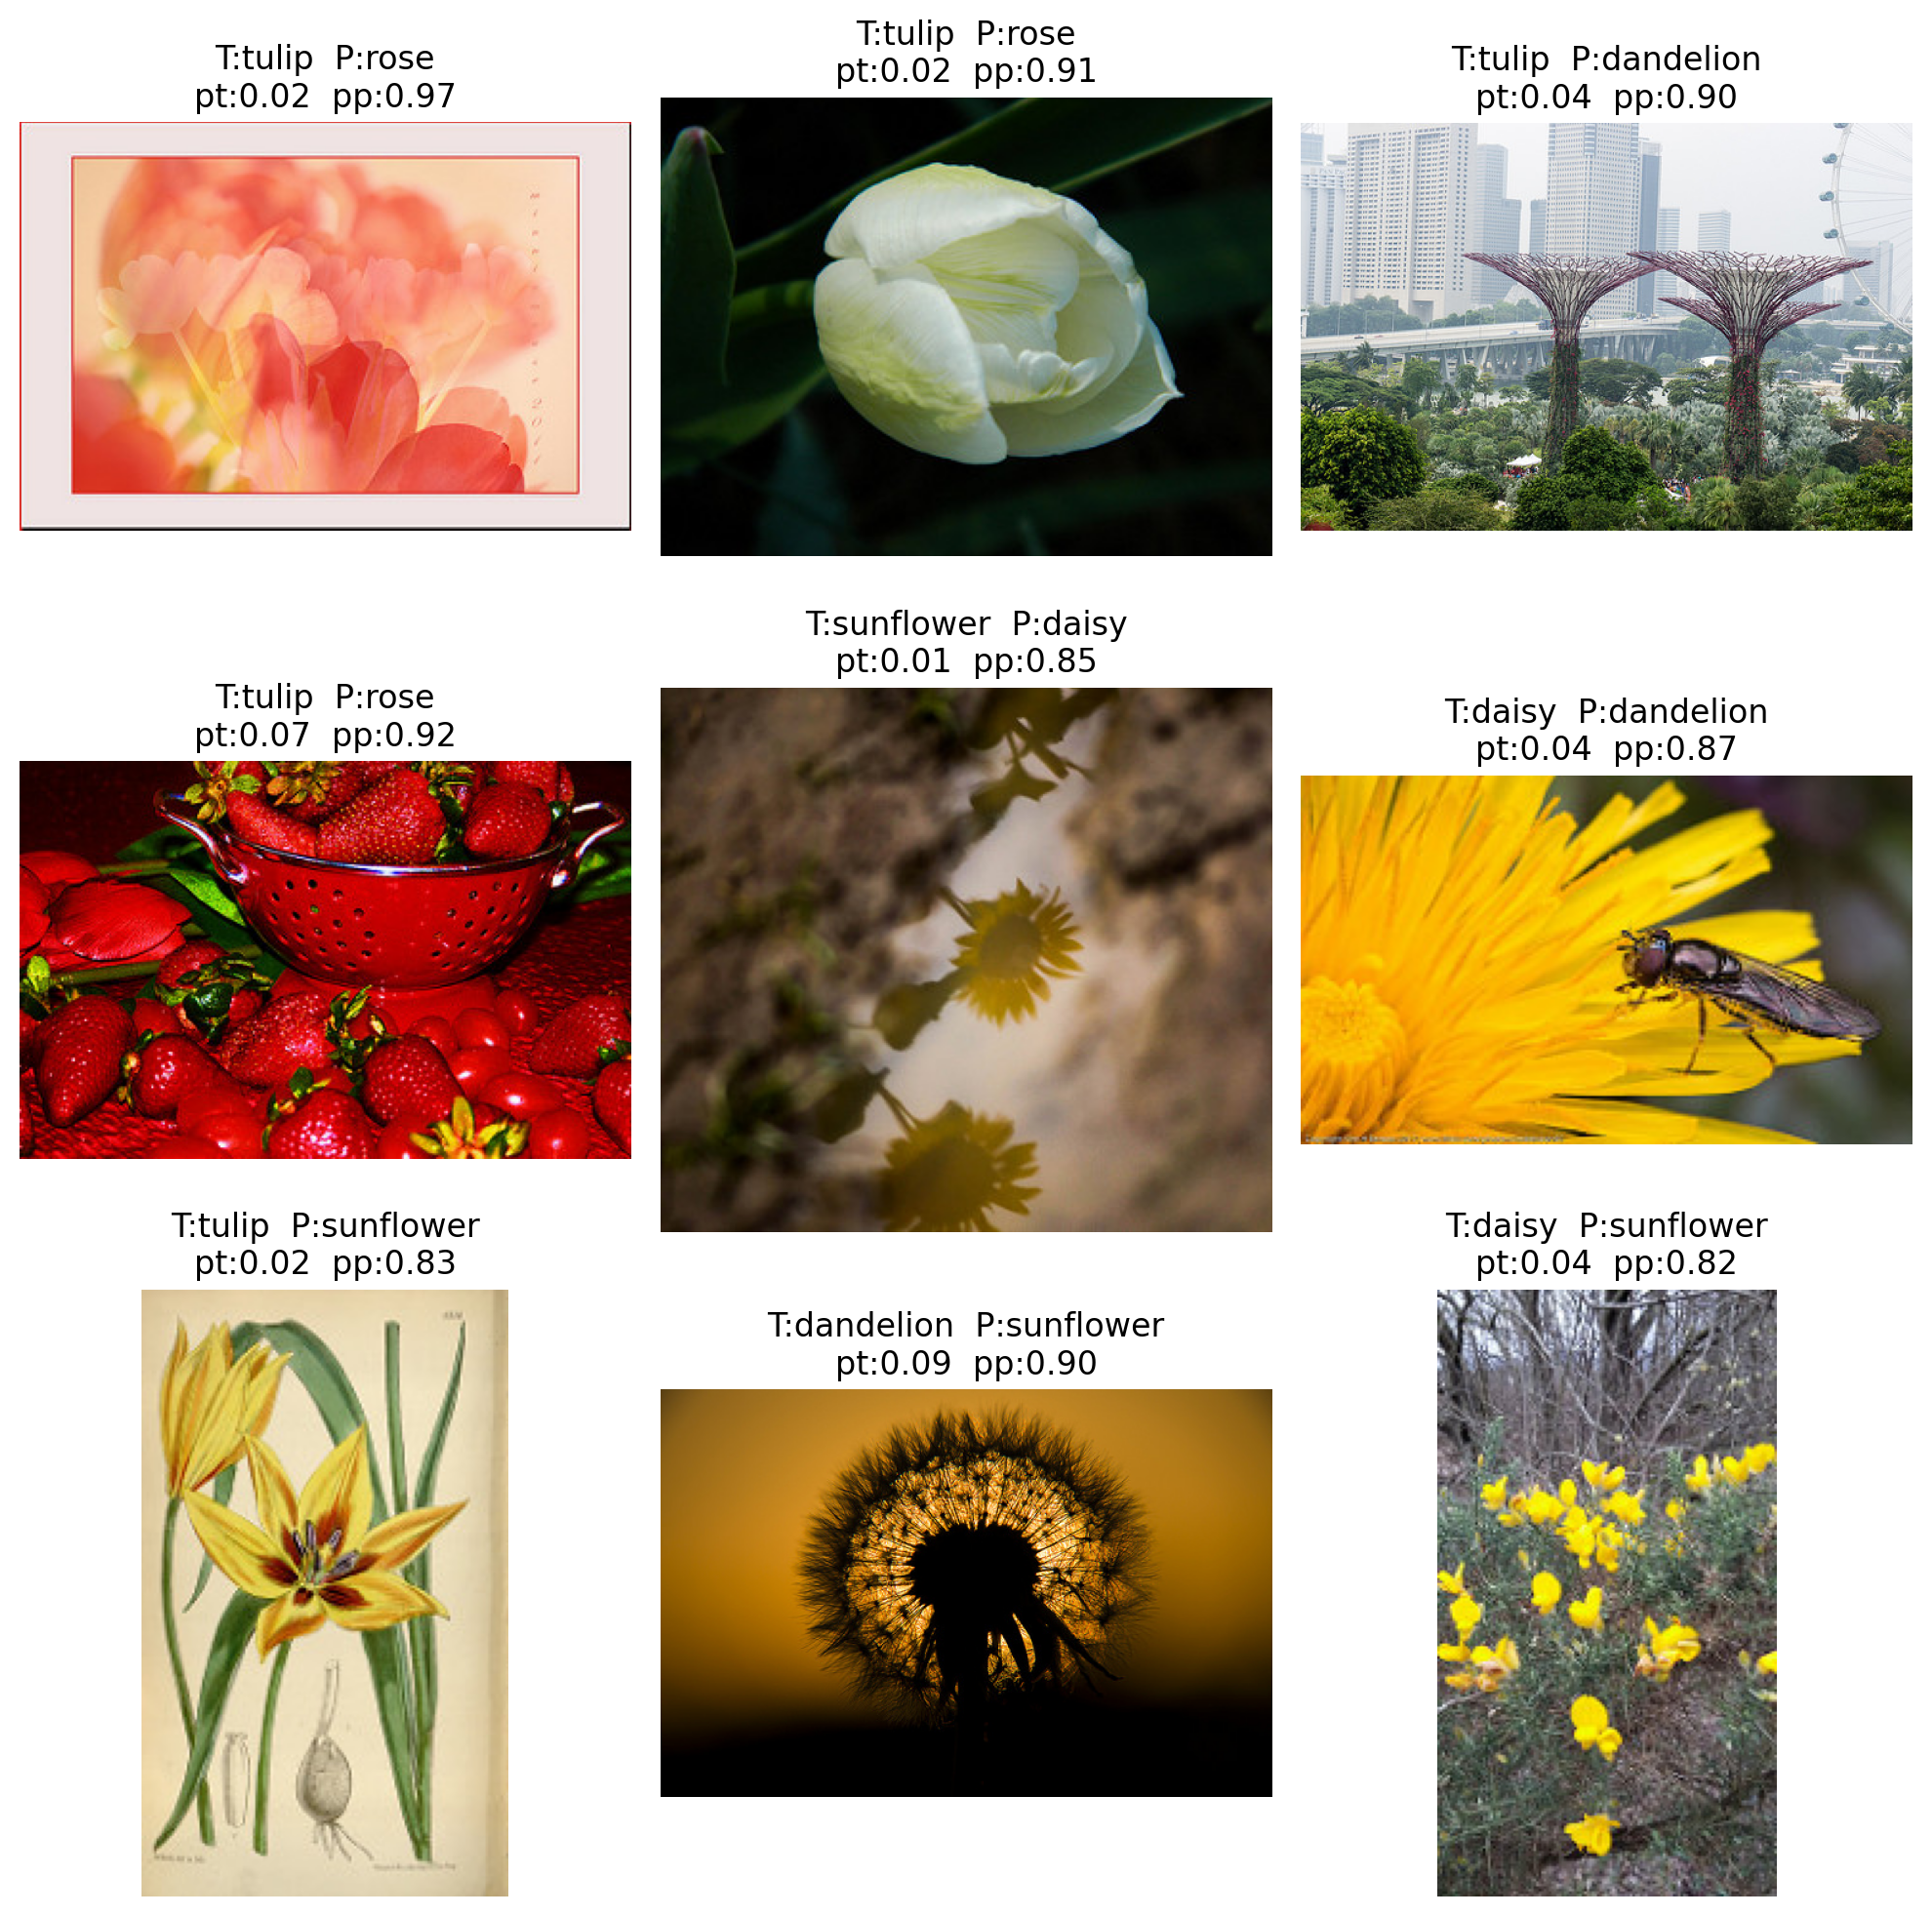

Total parameters: 22,245,957  (~84.9 MB of weights)
Approx MACs / forward pass: 0.483 G
  conv2d               Conv2D:    42.58 M
  conv2d_1             Conv2D:   218.99 M
  conv2d_2             Conv2D:   199.36 M
  dense                Dense :    22.15 M
  dense_1              Dense :     0.00 M
Params ↓ from current to: 110405


In [ ]:

# Imports (safe even if already imported above)

# 1) Evaluate the model using the validation set
best_ep = int(np.argmax(history.history['val_accuracy']))
val_acc_best   = float(history.history['val_accuracy'][best_ep])
train_acc_best = float(history.history['accuracy'][best_ep])

print(f"Best epoch: {best_ep+1}")
print(f"Validation accuracy (best): {val_acc_best:.4f}")
print(f"Training accuracy at that epoch: {train_acc_best:.4f}")
print(f"Train–Val gap: {train_acc_best - val_acc_best:+.4f}")

# sanity check with evaluate() on the restored model
val_steps = math.ceil(val_gen.n / val_gen.batch_size)
val_loss_eval, val_acc_eval = model.evaluate(val_gen, steps=val_steps, verbose=0)
print(f"evaluate() Validation accuracy: {val_acc_eval:.4f}")

# 2) Generate confusion matrix
val_gen.reset()
probs = model.predict(val_gen, verbose=0)
y_pred = probs.argmax(axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation Confusion Matrix')
plt.tight_layout(); plt.show()

# quick text readout of the trickiest classes (most mistakes per true class)
mistakes_per_class = (cm.sum(axis=1) - np.diag(cm))
for i, c in sorted(enumerate(labels), key=lambda t: -mistakes_per_class[t[0]]):
    print(f"{c:12s} errors: {int(mistakes_per_class[i])}  (support={cm[i].sum()})")

print("\nPer-class metrics (validation):")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

# 3) Build a DataFrame to inspect hard cases
filepaths = getattr(val_gen, "filepaths", None)
if filepaths is None:
    filepaths = [os.path.join(val_gen.directory, f) for f in val_gen.filenames]

df_pred = pd.DataFrame({
    "filepath": filepaths,
    "true_idx": y_true,
    "pred_idx": y_pred,
    "true": [labels[i] for i in y_true],
    "pred": [labels[i] for i in y_pred],
    "conf_pred": probs.max(axis=1),
    "conf_true": probs[np.arange(len(probs)), y_true]
})
df_pred["margin"] = df_pred["conf_pred"] - df_pred["conf_true"]  # >0 when model trusts the wrong class more

hard_mis = df_pred[df_pred["true_idx"] != df_pred["pred_idx"]].sort_values("margin", ascending=False)
print("\nTop 10 hardest misclassifications:")
display(hard_mis.head(10)[["true","pred","conf_true","conf_pred","margin","filepath"]])

# show a small gallery of the top-9 hardest mistakes
try:
    from PIL import Image
    k = min(9, len(hard_mis))
    if k > 0:
        plt.figure(figsize=(10,10))
        for i, (_, r) in enumerate(hard_mis.head(k).iterrows()):
            plt.subplot(3,3,i+1)
            img = Image.open(r["filepath"]).convert("RGB")
            plt.imshow(img); plt.axis("off")
            plt.title(f"T:{r['true']}  P:{r['pred']}\npt:{r['conf_true']:.2f}  pp:{r['conf_pred']:.2f}")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Gallery skipped:", e)

# 4) Rough model complexity

# (a) Parameter count and weight memory
params = model.count_params()
mem_mb = params * 4 / (1024**2)  # float32
print(f"Total parameters: {params:,}  (~{mem_mb:.1f} MB of weights)")

# (b) Robust MACs (multiply-accumulates) per forward pass for Conv2D and Dense
def _shape_list(t):
    if hasattr(t, "as_list"):
        t = t.as_list()
    return [int(x) if x is not None else None for x in list(t)]

def _in_out_hw_c(layer):
    # get (H,W,C) for input and output, robust across Keras versions
    if hasattr(layer, "input_shape") and layer.input_shape is not None:
        in_shape = layer.input_shape
    else:
        in_shape = K.int_shape(layer.input)

    if hasattr(layer, "output_shape") and layer.output_shape is not None:
        out_shape = layer.output_shape
    elif hasattr(layer, "compute_output_shape") and getattr(layer, "input_shape", None) is not None:
        out_shape = layer.compute_output_shape(layer.input_shape)
    else:
        out_shape = K.int_shape(layer.output)

    in_shape  = _shape_list(in_shape)
    out_shape = _shape_list(out_shape)
    in_h, in_w, in_c     = in_shape[1],  in_shape[2],  in_shape[3]
    out_h, out_w, out_c  = out_shape[1], out_shape[2], out_shape[3]
    return (in_h, in_w, in_c), (out_h, out_w, out_c)

def approx_macs_keras(model):
    total = 0
    details = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            (_, _, in_c), (out_h, out_w, out_c) = _in_out_hw_c(layer)
            k_h, k_w = layer.kernel_size
            macs = int(out_h * out_w * out_c * in_c * k_h * k_w)
            total += macs
            details.append((layer.name, "Conv2D", macs))
        elif isinstance(layer, tf.keras.layers.Dense):
            in_c  = int(_shape_list(K.int_shape(layer.input))[-1])
            out_c = int(layer.units)
            macs = int(in_c * out_c)
            total += macs
            details.append((layer.name, "Dense", macs))
    return total, details

macs_total, macs_layers = approx_macs_keras(model)
print(f"Approx MACs / forward pass: {macs_total/1e9:.3f} G")
for name, t, m in macs_layers:
    print(f"  {name:20s} {t:6s}: {m/1e6:8.2f} M")

# 5) Show how many params if we replace Flatten->Dense(256) with GAP->Dense(128)
small_model = Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'), layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'), layers.MaxPooling2D(2),
    layers.Conv2D(128,3, activation='relu', padding='same'), layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax'),
])
small_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Params ↓ from current to:", small_model.count_params())


In [17]:
#Step 6 implementation

IMG_SIZE = (224, 224)

labels = list((val_gen if 'val_gen' in globals() else train_gen).class_indices.keys())

phone_image_path = "phone_rose.jpeg"

# Load, fix orientation, force RGB, resize like validation
img = Image.open(phone_image_path)
img = ImageOps.exif_transpose(img).convert("RGB")
img = img.resize(IMG_SIZE)               
x = np.asarray(img).astype("float32")/255.0  # normalization 
x = np.expand_dims(x, axis=0)              # add batch dim

# Predict
probs = model.predict(x, verbose=0)[0]
pred_idx = int(np.argmax(probs))
pred_name = labels[pred_idx]

print(f"Predicted class: {pred_name}  (confidence: {probs[pred_idx]:.4f})")
print("Probabilities by class:")
for name, p in zip(labels, probs):
    print(f"  {name:10s} {p:.4f}")


E0000 00:00:1755430330.336175 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Predicted class: rose  (confidence: 0.7439)
Probabilities by class:
  daisy      0.0100
  dandelion  0.0000
  rose       0.7439
  sunflower  0.0001
  tulip      0.2460


In [18]:
#Step 7 implementation - L2 regularization

model_l2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer = tf.keras.regularizers.l2( 0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2( 0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 50
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                     restore_best_weights=True)
]

start_time_l2 = time.time()

history_l2 = model_l2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight, 
    callbacks=callbacks,
    verbose=1
)

end_time_l2 = time.time()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.3110 - loss: 2.6492 - val_accuracy: 0.4891 - val_loss: 1.5309
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.5445 - loss: 1.4271 - val_accuracy: 0.6025 - val_loss: 1.2859
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.6048 - loss: 1.2406 - val_accuracy: 0.5870 - val_loss: 1.2301
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.6137 - loss: 1.1696 - val_accuracy: 0.6134 - val_loss: 1.1293
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.6322 - loss: 1.0605 - val_accuracy: 0.6599 - val_loss: 1.0157
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.6385 - loss: 1.0339 - val_accuracy: 0.6444 - val_loss: 1.0156
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.6636 - loss: 0.9988 - val_accuracy: 0.6196 - val_loss: 1.1682
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.6741 - loss: 0.9430 - val_accu

In [19]:
# Implimentation - Batch normalization

model_bn = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 50
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                     restore_best_weights=True)
]

start_time_bn = time.time()

history_bn= model_bn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight, 
    callbacks=callbacks,
    verbose=1
)

end_time_bn = time.time()

Epoch 1/50


E0000 00:00:1755430708.185385 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.3553 - loss: 17.7924 - val_accuracy: 0.1755 - val_loss: 22.9415
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.4077 - loss: 1.4981 - val_accuracy: 0.1957 - val_loss: 2.4017
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.4563 - loss: 1.2052 - val_accuracy: 0.3866 - val_loss: 1.6826
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.5020 - loss: 1.1300 - val_accuracy: 0.4286 - val_loss: 1.3325
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.5364 - loss: 1.0995 - val_accuracy: 0.4286 - val_loss: 1.3025
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.5328 - loss: 1.1524 - val_accuracy: 0.4627 - val_loss: 1.3763
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.5341 - loss: 1.0989 - val_accuracy: 0.5839 - val_loss: 1.0553
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.5692 - loss: 1.0407 - val_accuracy: 0.4

In [20]:
# Peformance Analysis

# 1. Model valuation

models_dict = {
    "baseline": model,
    "l2": model_l2,
    "bn": model_bn
}
histories = {
    "baseline": history,
    "l2": history_l2,
    "bn": history_bn
}

labels = list(val_gen.class_indices.keys())
val_steps = math.ceil(val_gen.n / val_gen.batch_size)

def evaluate_model(name, m):
    # Accuracy & loss
    val_loss, val_acc = m.evaluate(val_gen, steps=val_steps, verbose=0)

    # Macro-F1
    val_gen.reset()
    probs = m.predict(val_gen, verbose=0)
    y_pred = probs.argmax(axis=1)
    y_true = val_gen.classes
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    # Convergence stats (best epoch)
    h = histories[name].history
    be = int(np.argmax(h["val_accuracy"]))
    return {
        "model": name,
        "val_acc": float(val_acc),
        "val_loss": float(val_loss),
        "macro_f1": float(macro_f1),
        "best_epoch": be + 1,
        "train_acc@best": float(h["accuracy"][be]),
        "val_acc@best": float(h["val_accuracy"][be]),
        "train_val_gap": float(h["accuracy"][be] - h["val_accuracy"][be]),
        "epochs_trained": len(h["val_accuracy"])
    }

rows = [evaluate_model(k, m) for k, m in models_dict.items()]
df_perf = pd.DataFrame(rows).sort_values("val_acc", ascending=False)
display(df_perf.round(4))


E0000 00:00:1755431107.216262 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


model  val_acc  val_loss  macro_f1  best_epoch  train_acc@best  \
0  baseline   0.7531    0.6596    0.7515          12          0.7635   
1        l2   0.7267    0.7876    0.7252          18          0.7403   
2        bn   0.6289    1.0073    0.6154          11          0.5939   

   val_acc@best  train_val_gap  epochs_trained  
0        0.7531         0.0104              17  
1        0.7267         0.0136              23  
2        0.6289        -0.0350              16

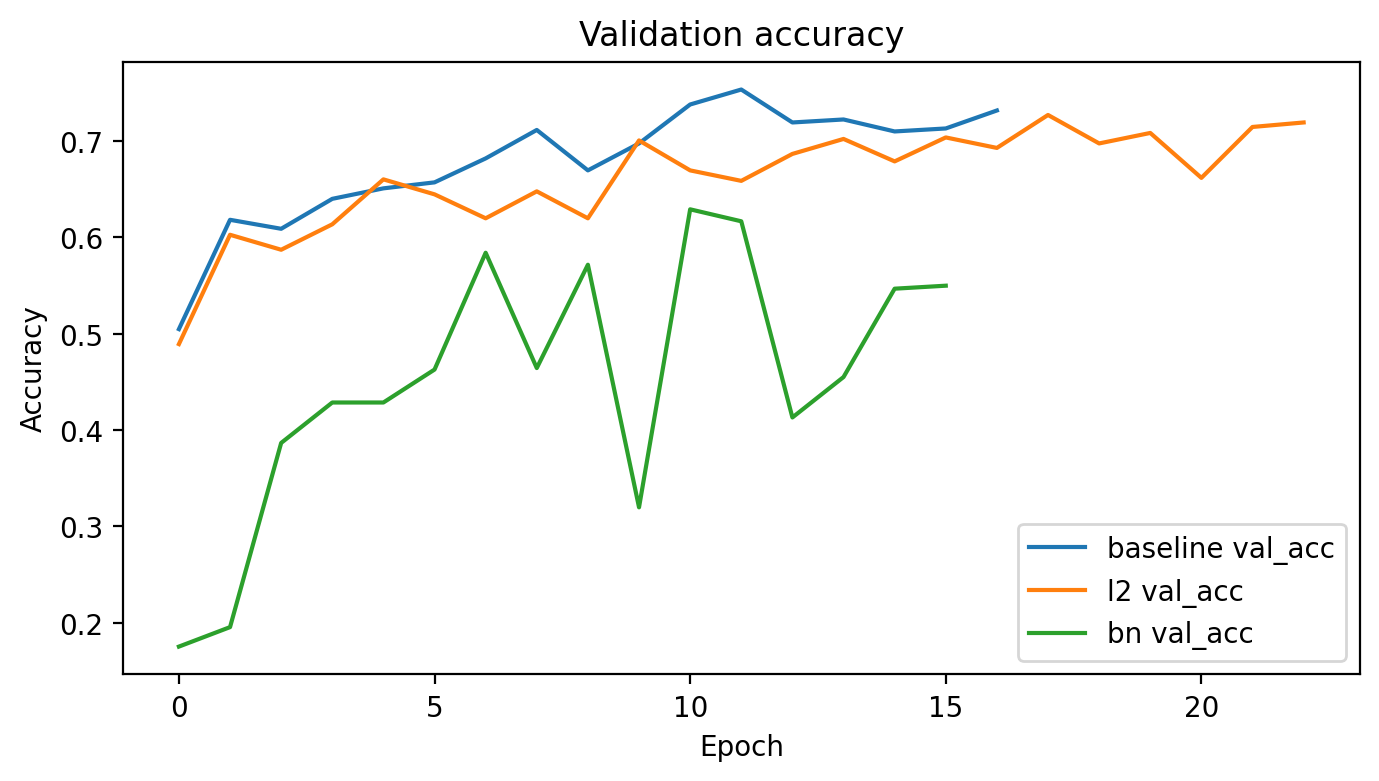

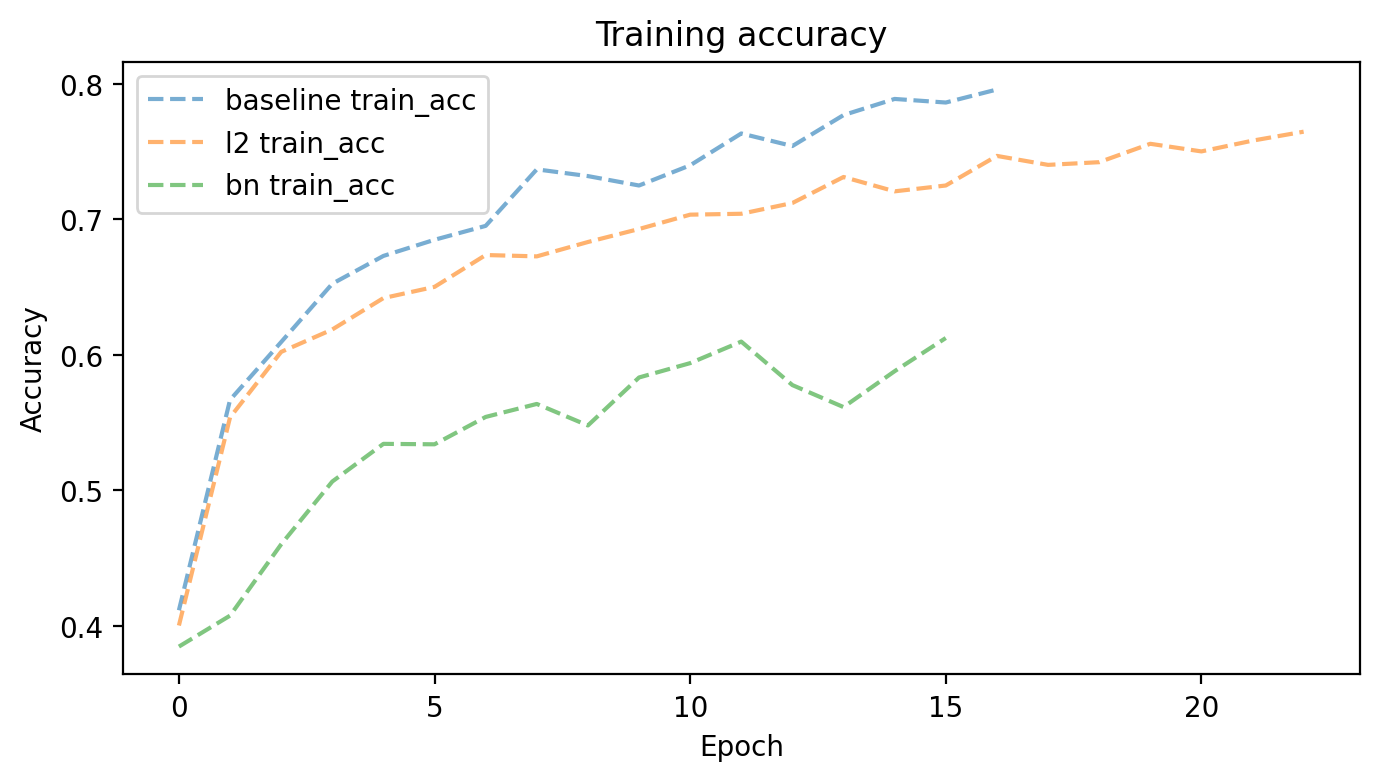

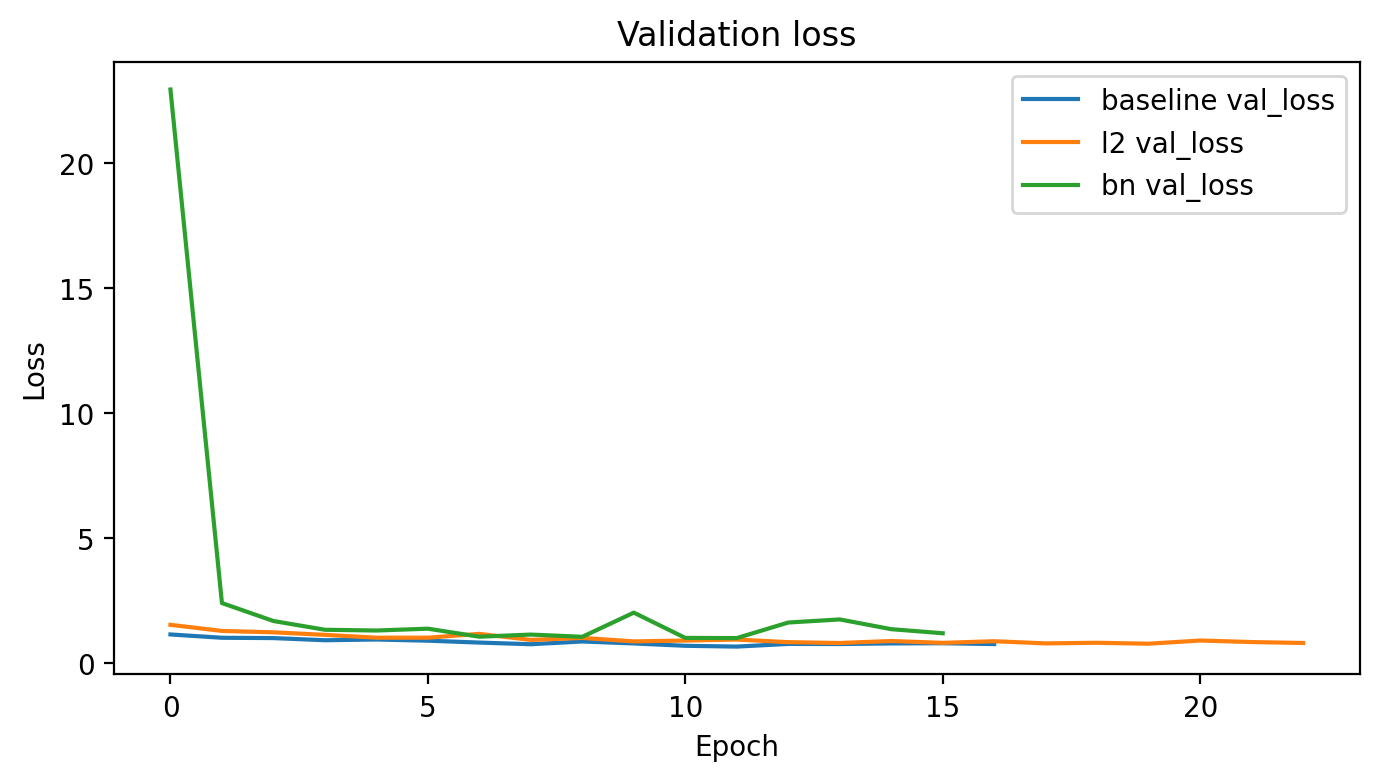

In [21]:
# 2. Convergence curves 

def get_hist_dict(h):
    return h.history if hasattr(h, "history") else h 

def pick(hist, *candidates):
    for k in candidates:
        if k in hist:
            return hist[k]
    return None

# --- Validation accuracy ---
plt.figure(figsize=(7,4))
for name, h in histories.items():
    hist = get_hist_dict(h)
    val_acc = pick(hist, "val_accuracy", "val_acc")
    if val_acc is not None:
        plt.plot(val_acc, label=f"{name} val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# --- Training accuracy ---
plt.figure(figsize=(7,4))
for name, h in histories.items():
    hist = get_hist_dict(h)
    tr_acc = pick(hist, "accuracy", "acc")
    if tr_acc is not None:
        plt.plot(tr_acc, "--", alpha=0.6, label=f"{name} train_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# --- Loss curves ---
plt.figure(figsize=(7,4))
for name, h in histories.items():
    hist = get_hist_dict(h)
    val_loss = pick(hist, "val_loss")
    if val_loss is not None:
        plt.plot(val_loss, label=f"{name} val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation loss")
plt.legend(); plt.tight_layout(); plt.show()


In [22]:
# 3. Model Size

models = {"baseline": model, "l2": model_l2, "bn": model_bn}

for name, m in models.items():
    try:
        params = m.count_params()
        mb = params * 4 / (1024**2)  # float32 weights
        print(f"\n=== {name.upper()} ===")
        print(f"Parameters: {params:,}  (~{mb:.1f} MB)")
        m.summary()
    except NameError:
        print(f"{name} model is not defined in this notebook.")




=== BASELINE ===
Parameters: 22,245,957  (~84.9 MB)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,737,873 (254.58 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,491,916 (169.72 MB)


=== L2 ===
Parameters: 22,245,957  (~84.9 MB)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,737,873 (254.58 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,491,916 (169.72 MB)


=== BN ===
Parameters: 22,246,853  (~84.9 MB)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,739,665 (254.59 MB)

 Trainable params: 22,246,405 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 44,492,812 (169.73 MB)

In [23]:
# 4. Inference Time

val_gen.reset()
x_batch, _ = next(iter(val_gen))
B = x_batch.shape[0]

def time_inference(model, x, repeats=20, warmup=5):
    # Warmup
    for _ in range(warmup):
        _ = model.predict(x, verbose=0)
    # Timed
    t0 = time.perf_counter()
    for _ in range(repeats):
        _ = model.predict(x, verbose=0)
    t1 = time.perf_counter()
    per_batch = (t1 - t0) / repeats
    return per_batch * 1000, (per_batch / x.shape[0]) * 1000  # ms/batch, ms/img

for k,m in models_dict.items():
    ms_batch, ms_img = time_inference(m, x_batch)
    print(f"{k:9s}  ~{ms_img:6.2f} ms/img  (batch={B}, ~{ms_batch:6.1f} ms/batch)")


E0000 00:00:1755431981.213152 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


baseline   ~  1.80 ms/img  (batch=32, ~  57.4 ms/batch)
l2         ~  1.76 ms/img  (batch=32, ~  56.2 ms/batch)
bn         ~  2.19 ms/img  (batch=32, ~  69.9 ms/batch)


In [25]:
# 5. Learned Weights

def conv_weight_stats(m):
    stats = []
    for lyr in m.layers:
        if isinstance(lyr, tf.keras.layers.Conv2D):
            w = lyr.get_weights()
            if not w: 
                continue
            k = w[0]                   # (kh,kw,in_c,out_c)
            norms = np.linalg.norm(k.reshape(-1, k.shape[-1]), axis=0)  # per-filter L2
            stats.append({
                "layer": lyr.name,
                "filters": k.shape[-1],
                "mean_L2": float(norms.mean()),
                "median_L2": float(np.median(norms)),
                "pct_small(<1e-3)": float((np.abs(k).ravel() < 1e-3).mean()*100)
            })
    return pd.DataFrame(stats)

def bn_stats(m):
    rows = []
    for lyr in m.layers:
        if isinstance(lyr, tf.keras.layers.BatchNormalization):
            gamma, beta, moving_mean, moving_var = lyr.get_weights()
            rows.append({
                "layer": lyr.name,
                "gamma_mean": float(gamma.mean()),
                "gamma_std": float(gamma.std()),
                "moving_var_mean": float(moving_var.mean())
            })
    return pd.DataFrame(rows) if rows else None

for name, m in models_dict.items():
    print(f"\n== {name.upper()} | Conv weight norms ==")
    display(conv_weight_stats(m).round(4))
    if name == "bn":
        print("== BN running stats ==")
        df_bn = bn_stats(m)
        if df_bn is not None:
            display(df_bn.round(4))
        else:
            print("(no BN layers found)")



== BASELINE | Conv weight norms ==


layer  filters  mean_L2  median_L2  pct_small(<1e-3)
0    conv2d       32   0.4503     0.4535            0.9259
1  conv2d_1       64   1.0449     1.0294            1.0145
2  conv2d_2      128   1.0021     0.9347            1.6113


== L2 | Conv weight norms ==


layer  filters  mean_L2  median_L2  pct_small(<1e-3)
0  conv2d_6       32   0.4533     0.4468            0.5787
1  conv2d_7       64   0.1697     0.0664           60.5903
2  conv2d_8      128   0.0686     0.0101           91.4103


== BN | Conv weight norms ==


layer  filters  mean_L2  median_L2  pct_small(<1e-3)
0   conv2d_9       32   0.4211     0.4155            0.6944
1  conv2d_10       64   0.8778     0.8604            1.4214
2  conv2d_11      128   0.8630     0.8614            1.6697

== BN running stats ==


layer  gamma_mean  gamma_std  moving_var_mean
0    batch_normalization      1.0012     0.0197           0.0042
1  batch_normalization_1      0.9992     0.0237           0.1906
2  batch_normalization_2      0.9629     0.0130           0.7802

In [ ]:
#Step 8 implementation

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # <-- IMPORTANT for VGG16
    rotation_range=25,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


NUM_CLASSES = 5

# Build base (frozen) 

base_model = keras.applications.VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False

# Classification head (a bit larger than before) 

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs, name="vgg16_transfer")

# Compile: Stage 1 (head only) 

loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.10)
opt1  = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt1, loss=loss, metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_stage1.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1
    ),
]

EPOCHS_STAGE1 = 15
t0 = time.time()
hist1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()

# Stage 2: unfreeze top of VGG16 and fine-tune 

# Unfreeze block5
unfreeze = False
for layer in base_model.layers:
    if layer.name.startswith("block5_"):
        unfreeze = True
    if unfreeze:
        layer.trainable = True

opt2 = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt2, loss=loss, metrics=["accuracy"])

callbacks_ft = [
    keras.callbacks.ModelCheckpoint(
        "best_finetune.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1
    ),
]

EPOCHS_STAGE2 = 20
t2 = time.time()
hist2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks_ft,
    verbose=1
)
t3 = time.time()

print(f"Stage 1 time: {t1 - t0:.1f}s | Stage 2 time: {t3 - t2:.1f}s")

# Evaluate

val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Final validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")


Epoch 1/15


E0000 00:00:1755434306.677792 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3852 - loss: 1.4662
Epoch 1: val_accuracy improved from -inf to 0.64130, saving model to best_stage1.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 407ms/step - accuracy: 0.3865 - loss: 1.4643 - val_accuracy: 0.6413 - val_loss: 1.1219 - learning_rate: 0.0010
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6845 - loss: 1.0408
Epoch 2: val_accuracy improved from 0.64130 to 0.72360, saving model to best_stage1.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 407ms/step - accuracy: 0.6847 - loss: 1.0405 - val_accuracy: 0.7236 - val_loss: 0.9869 - learning_rate: 0.0010
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7236 - loss: 0.9481
Epoch 3: val_accuracy improved from 0.72360 to 0.75776, saving model to best_stage1.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 407ms/step - accuracy: 0.7238 - loss: 0.9480 - val_accuracy: 0.7578 - val_loss: 0.9163 - learning_rate: 0.0010
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accura

E0000 00:00:1755434879.544957 3864860 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8463 - loss: 0.7262
Epoch 1: val_accuracy improved from -inf to 0.85559, saving model to best_finetune.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - accuracy: 0.8462 - loss: 0.7262 - val_accuracy: 0.8556 - val_loss: 0.7381 - learning_rate: 1.0000e-05
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8737 - loss: 0.6938
Epoch 2: val_accuracy improved from 0.85559 to 0.86491, saving model to best_finetune.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - accuracy: 0.8737 - loss: 0.6937 - val_accuracy: 0.8649 - val_loss: 0.7247 - learning_rate: 1.0000e-05
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8953 - loss: 0.6589
Epoch 3: val_accuracy did not improve from 0.86491
95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - accuracy: 0.8953 - loss: 0.6588 - val_accuracy: 0.8649 - val_loss: 0.7245 - learning_rate: 1.0000e-05
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9158 - loss: 0.63